## Modelagem: Detecção de Phishing - Melhora de Modelagem

Este notebook faz parte do projeto avaliativo da disciplina de Tópicos Computacionais em Ciência de Dados. O intuito deste projeto é realizar um estudo e tentativa de melhoria da modelagem de dados utilizada inicialmente.

Este notebook é responsável pela melhoria da modelagem dos dados.

Para esse Pipeline se adotou os dados disponibilizado no UCI, que pode ser acessado neste [link aqui](https://archive-beta.ics.uci.edu/dataset/327/phishing+websites).

### Sumário
1. Importações e Funções
2. Leitura dos dados
3. Visualização e Análise dos Dados
4. Modelagem Baseline
5. Novo Processo de Modelagem

**Desenvolvido por**
- Yago Aquino
- yagopacheco.34@gmail.com

## 1. Importações e Funções

Nesta seção vamos realizar a importações das bibliotecas e funções usadas ao longo do EDA.

In [27]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.1 MB/s eta 0:00:00


In [28]:
import os
import re
import warnings
import zipfile
import io

import numpy as np
import pandas as pd

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px

from scipy.stats import chi2_contingency
from scipy.io import arff

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate, train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             roc_auc_score, f1_score, precision_score, recall_score,
                             roc_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier
import shap
import optuna

from imblearn.combine import SMOTETomek

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.6f}'.format)
warnings.filterwarnings('ignore')

### 1.1 Funções

In [35]:
def read_zip_arff(zip_path, file_name=None):
  with zipfile.ZipFile('/content/phishing+websites.zip', 'r') as zip_file:
    arquivos = zip_file.namelist()
    print("Arquivos no ZIP:", arquivos, '\n')

    if file_name is not None:
      with zip_file.open(file_name) as file:
          content = file.read().decode('utf-8')

      data, meta = arff.loadarff(io.StringIO(content))
      df = pd.DataFrame(data)

      return df


def avalia_valores_nulos(df, tamanho_df):
  new_df = df.isna().sum().to_frame().rename(columns={0: 'QTD_NULOS'})
  new_df['%_NULOS'] = round(new_df['QTD_NULOS'] / tamanho_df * 100, 2)
  new_df = new_df[new_df['%_NULOS'] > 0].sort_values('%_NULOS', )

  return new_df


def barplot(df, x, y, xlab=None, ylab=None, title=None, order_desc=False, figsize=(8, 6)):
  if order_desc:
      # Ordena o DataFrame pelo y em ordem decrescente
      df_sorted = df.sort_values(by=y, ascending=False)
      order = df_sorted[x].tolist()
  else:
      order = None

  fig, ax = plt.subplots(figsize=figsize)
  bar = sns.barplot(df, x=x, y=y, ax=ax, order=order)

  bars = bar.containers[0]
  bar_qtd = [rect.get_height() for rect in bars]
  labels = [f'{v:.0f} ({v/(sum(bar_qtd)):.1%})' for v in bar_qtd]
  ax.bar_label(bars, labels=labels, padding=5)

  sns.despine(offset=10)
  ax.set_title(title)
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab);


def plot_chi2_heatmap(df, title="Análise do Coeficiente de Contingência para Cada Variável Nominal", figsize=(12, 10), show_legend=True, annot_size=8):

  def chi2_analysis(variable1, variable2):
      if variable1.equals(variable2):
          return 1.0

      contingency_table = pd.crosstab(variable1, variable2)
      chi2, _, _, _ = chi2_contingency(contingency_table)
      n = contingency_table.values.sum()

      if (chi2 + n) == 0:
          return 0.0

      contingency_coef = np.sqrt(chi2 / (chi2 + n))
      return contingency_coef

  variables = df.columns.tolist()
  n_variables = len(variables)
  df_matrix = np.zeros((n_variables, n_variables))

  for i in range(n_variables):
      for j in range(n_variables):
          if i == j:
              df_matrix[i, j] = 1.0
          else:
              result = chi2_analysis(df[variables[i]], df[variables[j]])
              df_matrix[i, j] = result

  category_bounds = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
  categories = ['Muito Fraca', 'Fraca', 'Moderada', 'Forte', 'Muito Forte']

  df_heatmap = pd.DataFrame(df_matrix, index=variables, columns=variables)

  colors = sns.color_palette('coolwarm', len(categories))
  cmap = ListedColormap(colors)

  fig, ax = plt.subplots(figsize=figsize)

  sns.heatmap(df_heatmap,
              cmap=cmap,
              fmt=".3f",
              cbar=False,
              ax=ax,
              linewidths=1,
              linecolor='white',
              vmin=0,
              vmax=1,
              annot=True,
              annot_kws={"size": annot_size},
              square=True)

  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
  ax.set_title(title, fontsize=14, pad=20)

  if show_legend:
      legend_labels = [f'{category}: {category_bounds[i]:.1f} - {category_bounds[i+1]:.1f}'
                        for i, category in enumerate(categories)]
      legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=colors[i])
                        for i in range(len(categories))]

      legend_elements = legend_elements[::-1]
      legend_labels = legend_labels[::-1]

      ax.legend(handles=legend_elements,
                labels=legend_labels,
                loc='center left',
                bbox_to_anchor=(1.02, 0.5),
                title='Força da Associação')

  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

  return df_heatmap


def confusion_plot(cm):
  plt.figure(figsize=(10, 5))

  cmap = 'Blues'
  fmt = 'd'

  sns.heatmap(
      cm,
      annot=True,
      fmt=fmt,
      cmap=cmap,
      cbar_kws={'shrink': 0.8}
  )

  plt.title('Matriz de Confusão', fontsize=14)
  plt.xlabel('Predito', fontsize=12)
  plt.ylabel('Real', fontsize=12)

  ax = plt.gca()
  ax.set_xticklabels(['Normal', 'Ataque'])
  ax.set_yticklabels(['Normal', 'Ataque'])

  plt.tight_layout()
  plt.show()


def plot_roc_curve(y_test, y_prob, model_name="Model"):
  fpr, tpr, _ = roc_curve(y_test, y_prob)
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='darkorange', lw=2,
            label=f'{model_name} (AUC = {roc_auc:.3f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
            label='Random Classifier (AUC = 0.5)')

  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curve - {model_name}')
  plt.legend(loc="lower right")
  plt.grid(True, alpha=0.3)
  plt.show()


def plot_roc_comparison(models_results):
  plt.figure(figsize=(10, 8))

  for model_name, (y_test, y_prob) in models_results.items():
      fpr, tpr, _ = roc_curve(y_test, y_prob)
      roc_auc = auc(fpr, tpr)
      plt.plot(fpr, tpr, lw=2,
              label=f'{model_name} (AUC = {roc_auc:.3f})')

  plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5,
            label='Random Classifier (AUC = 0.5)')

  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve Comparison')
  plt.legend(loc="lower right")
  plt.grid(True, alpha=0.3)
  plt.show()


# Tentativa de hiperparametrização
RANDOM_STATE = 42
N_TRIALS = 50
CV_FOLDS = 5

cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

def objective_lr(trial):
    params = {
        'C': trial.suggest_float('C', 0.001, 100, log=True),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga']),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'random_state': RANDOM_STATE
    }

    if params['solver'] == 'liblinear':
        params['penalty'] = trial.suggest_categorical('penalty_lib', ['l1', 'l2'])
    elif params['solver'] == 'saga':
        params['penalty'] = trial.suggest_categorical('penalty_saga', ['l1', 'l2', 'elasticnet', None])
        if params['penalty'] == 'elasticnet':
            params['l1_ratio'] = trial.suggest_float('l1_ratio', 0, 1)
    else:
        params['penalty'] = 'l2'

    model = LogisticRegression(**params)
    scores = cross_val_score(model, X_balanced, y_balanced, cv=cv, scoring='f1')
    return scores.mean()


def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample']),
        'random_state': RANDOM_STATE,
        'n_jobs': -1
    }

    model = RandomForestClassifier(**params)
    scores = cross_val_score(model, X_balanced, y_balanced, cv=cv, scoring='f1')
    return scores.mean()


def objective_lgbm(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 10, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'random_state': RANDOM_STATE,
        'verbosity': -1,
        'n_jobs': -1
    }

    model = LGBMClassifier(**params)
    scores = cross_val_score(model, X_balanced, y_balanced, cv=cv, scoring='f1')
    return scores.mean()


def optimize_model(objective_func, model_name, n_trials=N_TRIALS):
  """Otimiza hiperparâmetros usando Optuna"""
  print(f"\n{'='*50}")
  print(f"Otimizando {model_name}")
  print(f"{'='*50}")

  study = optuna.create_study(
      direction='maximize',
      study_name=f'{model_name}_optimization',
      sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
  )

  study.optimize(
      objective_func,
      n_trials=n_trials,
      show_progress_bar=True
  )

  print(f"\nMelhor F1-Score: {study.best_value:.4f}")
  print(f"Melhores parâmetros:")
  for key, value in study.best_params.items():
      print(f"  {key}: {value}")

  return study


def clean_lr_params(params):
  cleaned = {}

  for key, value in params.items():
      if key not in ['penalty_lib', 'penalty_saga']:
          cleaned[key] = value

  if 'penalty_lib' in params:
      cleaned['penalty'] = params['penalty_lib']
  elif 'penalty_saga' in params:
      cleaned['penalty'] = params['penalty_saga']
  else:
      cleaned['penalty'] = 'l2'

  if cleaned.get('penalty') != 'elasticnet' and 'l1_ratio' in cleaned:
      del cleaned['l1_ratio']

  return cleaned

## 2. Leitura, Visualização dos dados

Nesta seção vamos realizar a leitura dos dados, sua visualização e verificação da sua qualidade, além de simples transformações para o seu uso.

In [3]:
df = read_zip_arff('/content/phishing+websites.zip', file_name='Training Dataset.arff')

print(df.shape)
df.head()

Arquivos no ZIP: ['.old.arff', 'Training Dataset.arff', 'Phishing Websites Features.docx'] 

(11055, 31)


,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor,Links_in_tags,SFH,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,b'-1',b'1',b'1',b'1',b'-1',b'-1',b'-1',b'-1',b'-1',b'1',b'1',b'-1',b'1',b'-1',b'1',b'-1',b'-1',b'-1',b'0',b'1',b'1',b'1',b'1',b'-1',b'-1',b'-1',b'-1',b'1',b'1',b'-1',b'-1'
1,b'1',b'1',b'1',b'1',b'1',b'-1',b'0',b'1',b'-1',b'1',b'1',b'-1',b'1',b'0',b'-1',b'-1',b'1',b'1',b'0',b'1',b'1',b'1',b'1',b'-1',b'-1',b'0',b'-1',b'1',b'1',b'1',b'-1'
2,b'1',b'0',b'1',b'1',b'1',b'-1',b'-1',b'-1',b'-1',b'1',b'1',b'-1',b'1',b'0',b'-1',b'-1',b'-1',b'-1',b'0',b'1',b'1',b'1',b'1',b'1',b'-1',b'1',b'-1',b'1',b'0',b'-1',b'-1'
3,b'1',b'0',b'1',b'1',b'1',b'-1',b'-1',b'-1',b'1',b'1',b'1',b'-1',b'-1',b'0',b'0',b'-1',b'1',b'1',b'0',b'1',b'1',b'1',b'1',b'-1',b'-1',b'1',b'-1',b'1',b'-1',b'1',b'-1'
4,b'1',b'0',b'-1',b'1',b'1',b'-1',b'1',b'1',b'-1',b'1',b'1',b'1',b'1',b'0',b'0',b'-1',b'1',b'1',b'0',b'-1',b'1',b'-1',b'1',b'-1',b'-1',b'0',b'-1',b'1',b'1',b'1',b'1'


Um ponto a se destacar aqui é que os dados já estão pré-processados e essas informações de como foi realizado essa categorização das colunas em -1, 0 e 1 pode ser lida no artigo `An assessment of features related to phishing websites using an automated technique` dos autores dos dados. Essas categorias são definidas por:

-  1 : Indica a presença de uma característica de phishing.
-  0 : Indica a presença de uma característica de um site legítimo.
- -1 : Indica a presença de uma característica suspeita (um meio-termo entre legítimo e phishing).

In [4]:
# Removendo os "b" resultante da transformação do arf para csv
for col in df.columns:
  if df[col].dtype == 'object':
    df[col] = df[col].astype(str).str.replace("b'", '').str.replace("'", '').astype(int)

print(df.shape)
df.head()

(11055, 31)


,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor,Links_in_tags,SFH,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,-1,0,1,1,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,1,-1,1,0,-1,-1,1,1,0,1,1,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,1,-1,1,0,-1,-1,-1,-1,0,1,1,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,1,-1,-1,0,0,-1,1,1,0,1,1,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,1,1,1,0,0,-1,1,1,0,-1,1,-1,1,-1,-1,0,-1,1,1,1,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   having_IP_Address            11055 non-null  int64
 1   URL_Length                   11055 non-null  int64
 2   Shortining_Service           11055 non-null  int64
 3   having_At_Symbol             11055 non-null  int64
 4   double_slash_redirecting     11055 non-null  int64
 5   Prefix_Suffix                11055 non-null  int64
 6   having_Sub_Domain            11055 non-null  int64
 7   SSLfinal_State               11055 non-null  int64
 8   Domain_registeration_length  11055 non-null  int64
 9   Favicon                      11055 non-null  int64
 10  port                         11055 non-null  int64
 11  HTTPS_token                  11055 non-null  int64
 12  Request_URL                  11055 non-null  int64
 13  URL_of_Anchor                11055 non-null  i

In [6]:
# Verificando os nulos, com a célula de cima já era possível visualizar mas aqui deixa mais evidente
avalia_valores_nulos(df, df.shape[0])

,QTD_NULOS,%_NULOS


In [7]:
# Verificando duplicatas
df.duplicated().sum()

np.int64(5206)

Aqui não vale a pena deletar as duplicatas, pois nossos dados estão pré-processados e essas duplictas provavel que são de sistes que tem caracteristicas em comum, algo que já era esperado.

De forma geral os dados tem uma boa qualidade, visto que foram criados já com o intuito de ser usado para a modelagem. Com isso, todo o processo de coleta, tratamento e processamento já foi realizado o que deixa esses dados pronto para o consumo.

## 3. Visualização e Análise dos Dados

Nesta seção será feita uma rápida visualização e análise dos dados. Visto que as colunas e os dados estão mascarados e normalizados, a nossa visualização e análise se tornam limitadas, por isso será apenas uma seção curta.

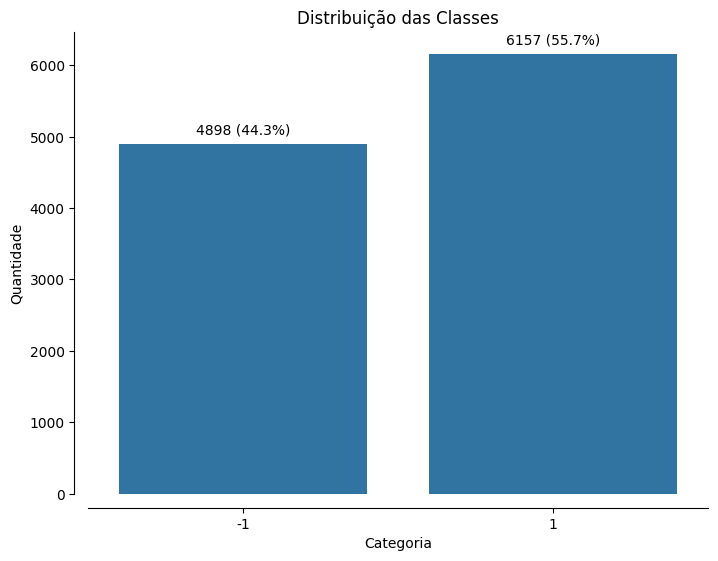

In [8]:
# Verificando o balanceamento das classes
df_temp = df['Result'].value_counts().to_frame().reset_index()
barplot(
    df_temp,
    x='Result',
    y='count',
    xlab='Categoria',
    ylab='Quantidade',
    title='Distribuição das Classes'
)

Para a nossa próxima análise vamos verificar a independência das variáveis por meio do teste de Chi². Vamos usar ele em vez do teste de correlação pelo fato dos valores das nossas colunas serem catgeóricas, mesmo estando tipadas como numéricas. Conforme é apresentado pelos autores dos dados no artigo e do documento de auxilio das features os valores `-1`, `0` e `1` são frutos de transformações.

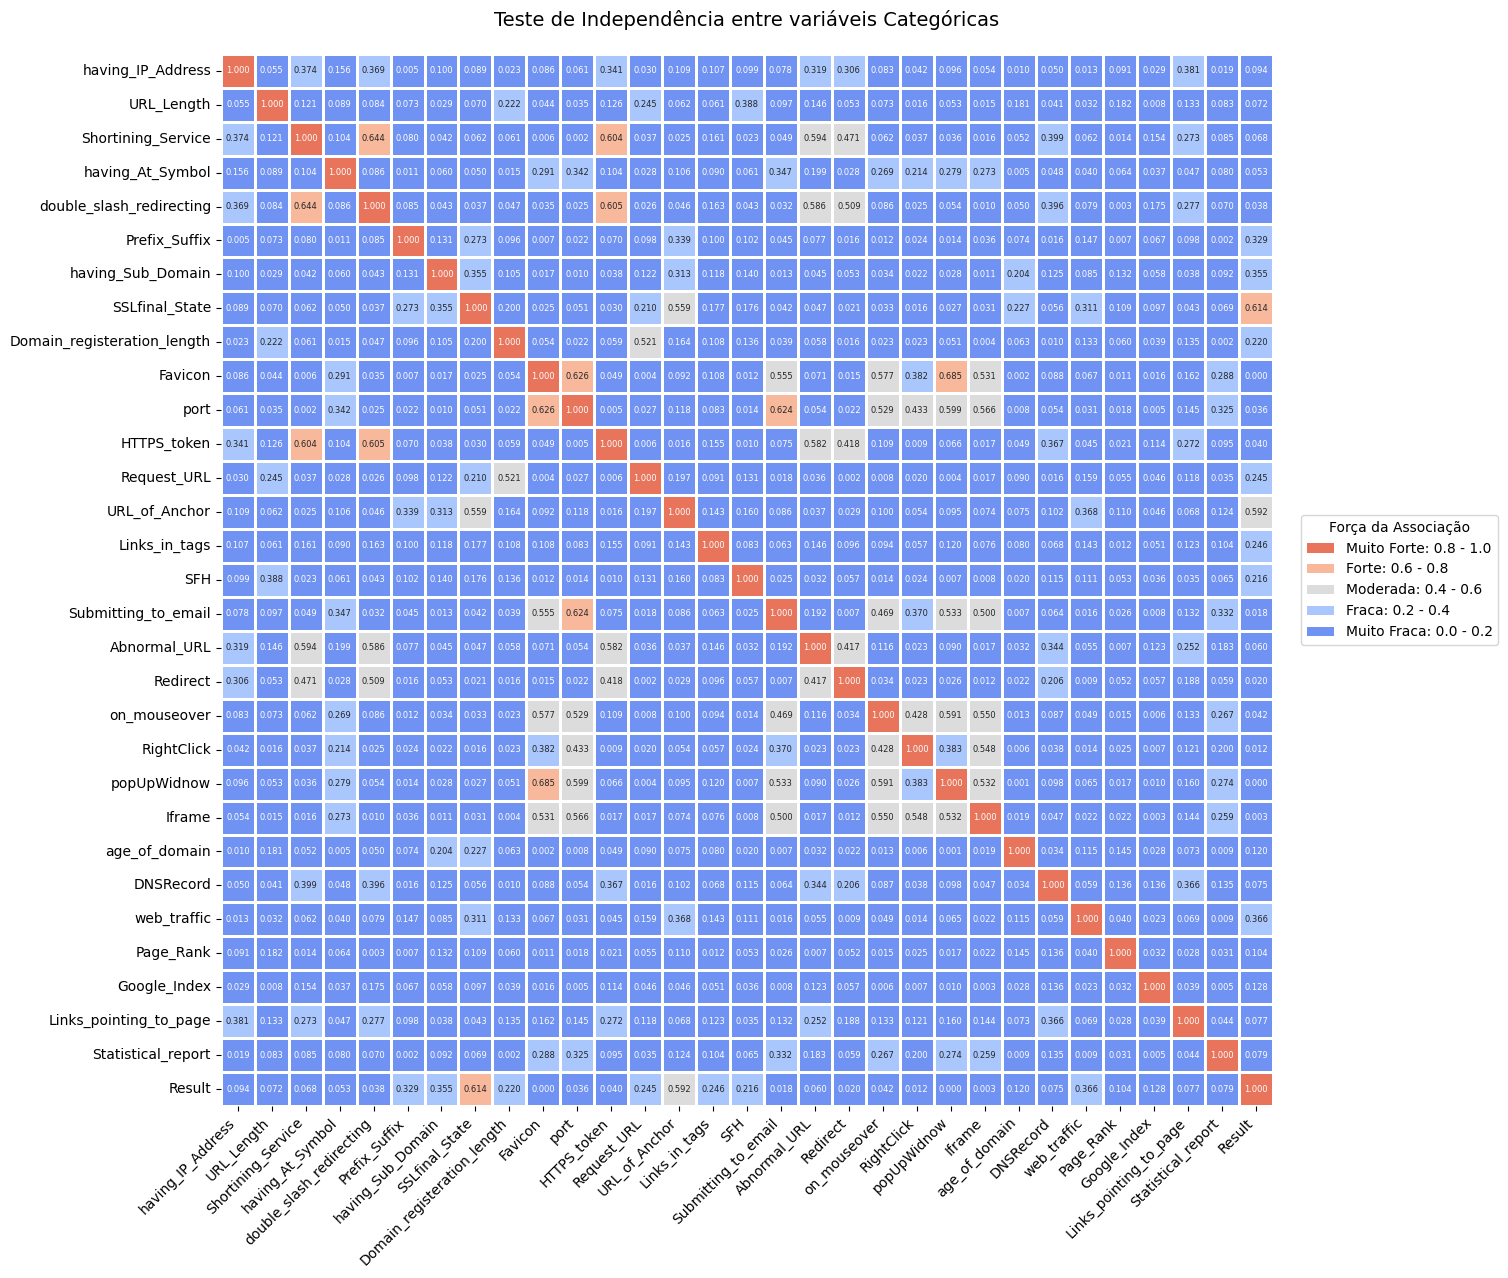

In [9]:
tabela_chi2 = plot_chi2_heatmap(df, title="Teste de Independência entre variáveis Categóricas", figsize=(30, 14), show_legend=True, annot_size=6)

Quando olhamos para a nossa coluna `Results` e algumas features em especial chamam a nossa atenção. Indo de uma associação forte a uma associação fraca.

- **SSLfinal_State**: Esta feature verifica a validade e a confiança do certificado SSL/TLS do site. Ela não apenas confere a existência do protocolo HTTPS, mas também avalia a autoridade certificadora (ex: GoDaddy, VeriSign) e a idade do certificado. Um valor -1 indica um HTTPS totalmente confiável, 0 um HTTPS suspeito (certificado não confiável ou expirado), e 1 indica a ausência de HTTPS.

- **Prefix_Suffix**: Verifica a presença do caractere hífen (-) no nome de domínio da URL.

- **URL_of_Anchor**: Esta feature analisa os links (tags) dentro da página. Ela mede a percentagem de "âncoras" que apontam para domínios diferentes do domínio principal da página ou que não apontam para lugar nenhum.

- **having_Sub_Domain**: Esta feature analisa o número de subdomínios na URL. A regra geralmente classifica URLs com múltiplos subdomínios (ex: login.conta.banco.sitefalso.com) como suspeitas ou phishing.

- **web_traffic**: Mede a popularidade do site através do seu ranking em serviços como o Alexa. A regra assume que se um site não tem tráfego ou não está classificado entre os mais populares (ex: top 100.000), é provavelmente phishing.

- **Links_in_tags**: Esta feature é uma verificação técnica que analisa o código-fonte da página web, focando especificamente nos links encontrados dentro das tags HTML

Para uma melhor compreensão vamos verificar a distribuição dessas features em especifico, em vez de olhar todas as 29 colunas.

In [10]:
top_features = ['SSLfinal_State', 'URL_of_Anchor', 'having_Sub_Domain', 'web_traffic', 'Prefix_Suffix', 'Links_in_tags']

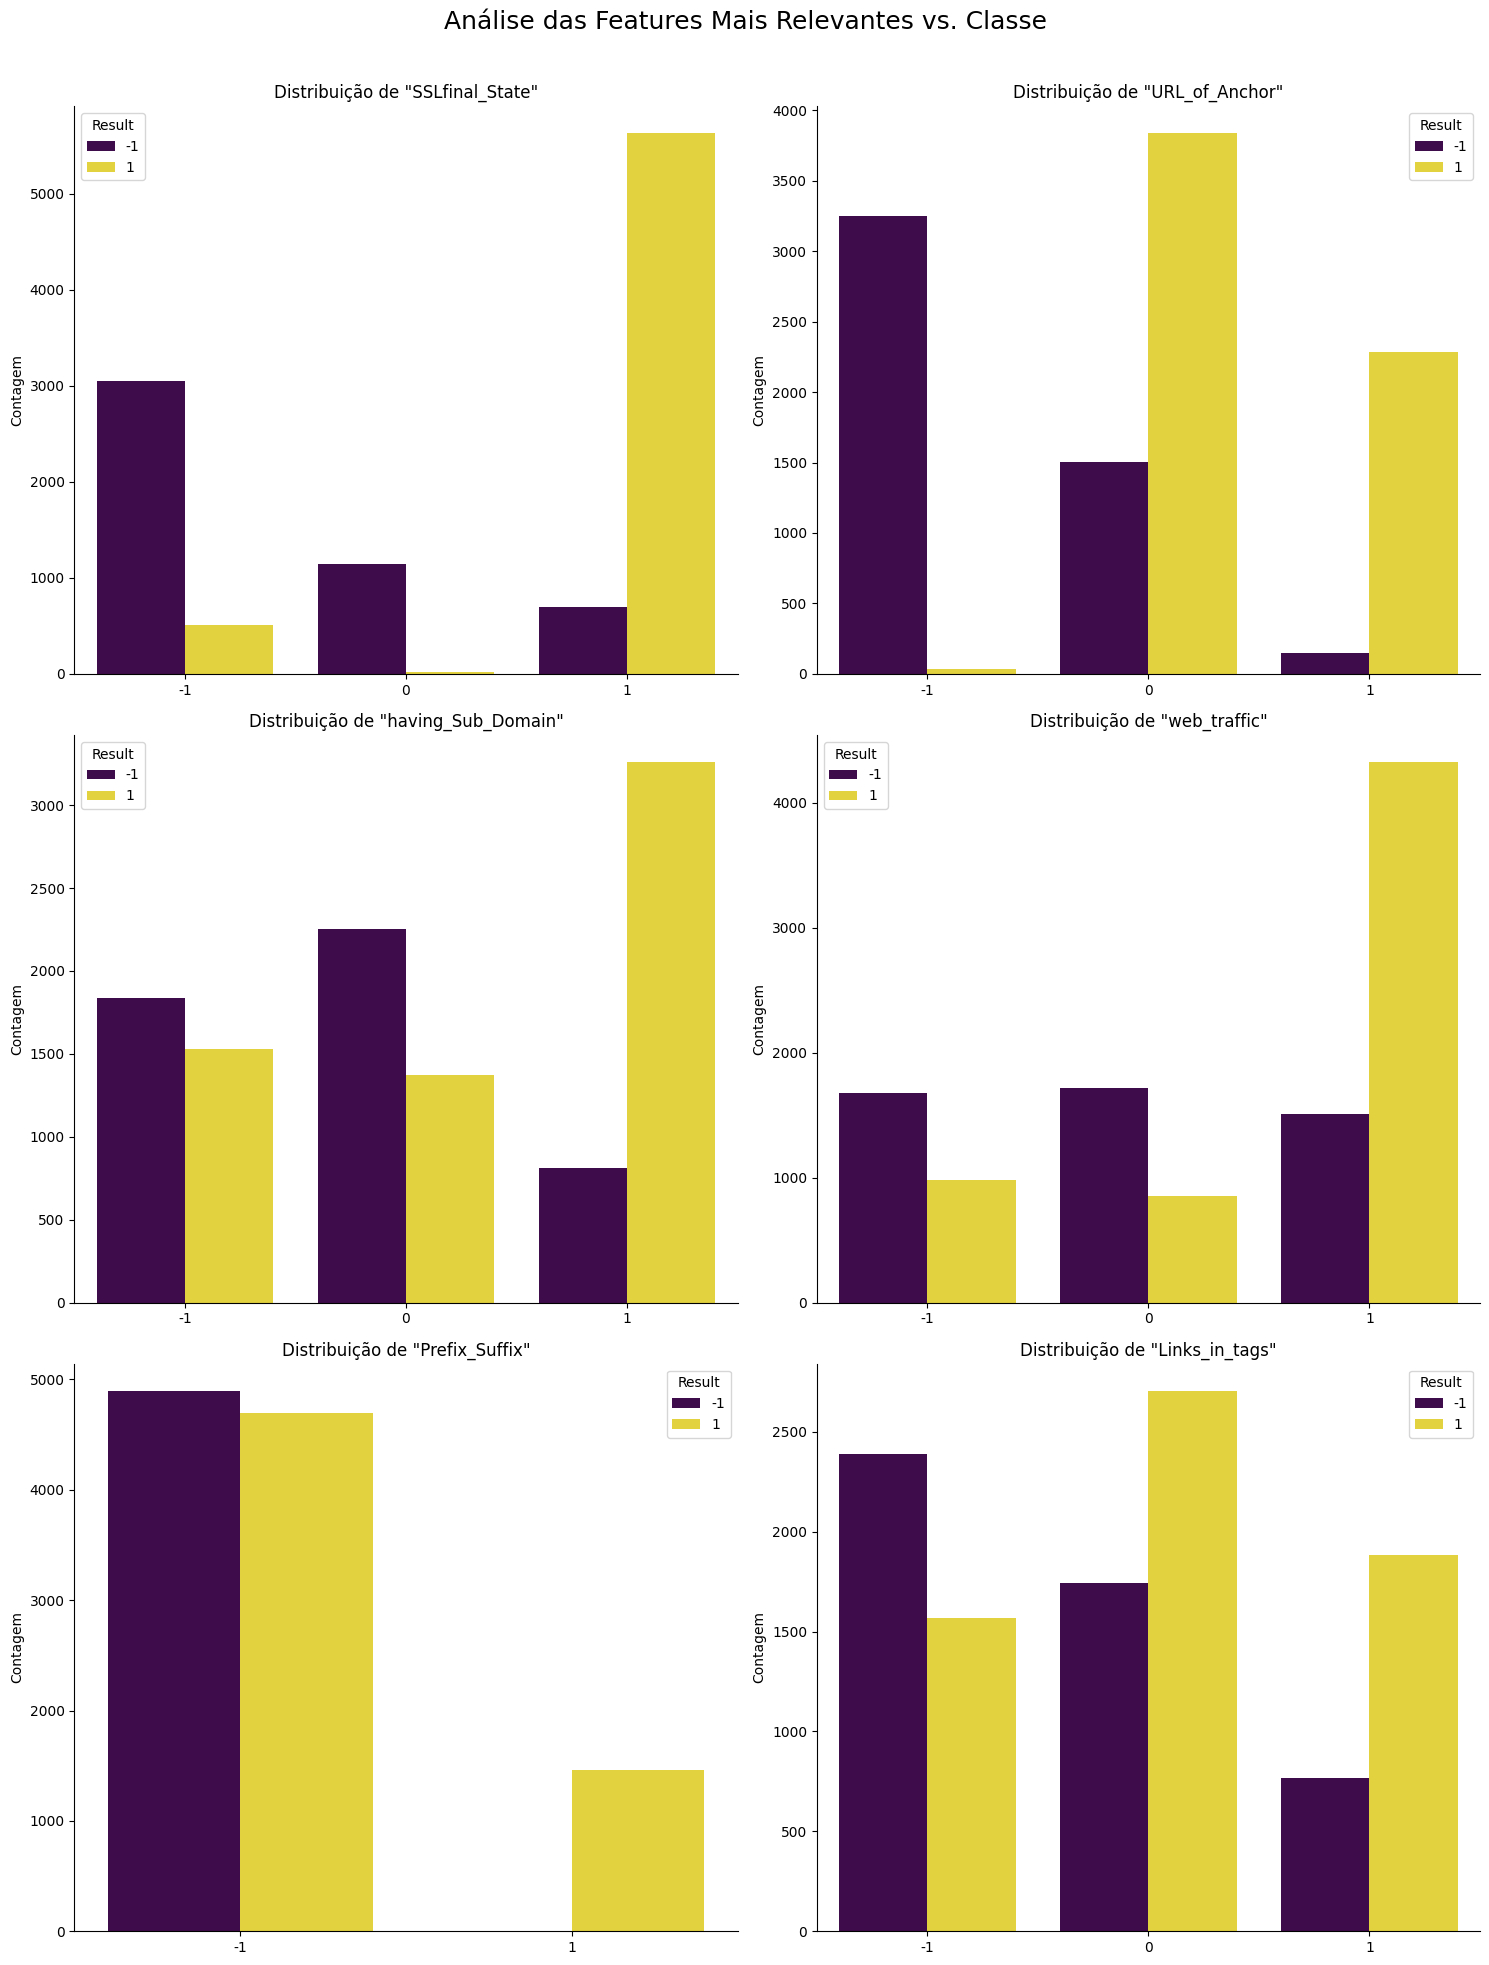

In [11]:
n_rows = 3
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))

fig.suptitle('Análise das Features Mais Relevantes vs. Classe', fontsize=18)

axes = axes.flatten()

for i, feature_name in enumerate(top_features):
    sns.countplot(x=feature_name, data=df, hue='Result', ax=axes[i], palette='viridis')
    axes[i].set_title(f'Distribuição de "{feature_name}"', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Contagem')

    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

for i in range(len(top_features), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Verificando a distribuição conseguimos compreender a importância dessas features. Pirncipalmente a `SSLFinal_State` que apresenta uma boa divisão dos atributos de quando classificamos rótulo como Phishing. Mas é interessante dar uma olhada na coluna `Prefix_Suffix` também. Aparenta ser interessante para verificar quando não e Phishing.

## 4. Modelagem Baseline

Nesta seção vamos apenas replicar o processo realizado na modelagem inicial a fim de utilizar como baseline e buscar melhorias. Além disso, vamos gerar algumas visualizações a mais dos resultados anteriores.

In [12]:
# Separando as variáveis de treino e teste
X = df.drop('Result', axis=1)
y = df['Result']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Treino: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras\n")

Treino: 8844 amostras
Teste: 2211 amostras



In [13]:
# Instanciando os modelos
models = {
    'Regressão Logística': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'LGBM': LGBMClassifier(random_state=42, verbose=-1)
}

cv_results = {}

scoring_metrics = ['accuracy', 'f1', 'recall', 'precision', 'roc_auc']

for name, model in models.items():
  print(f"\n{name}:")

  cv_results[name] = {}

  for metric in scoring_metrics:
      cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=metric)
      cv_results[name][metric] = {
          'mean': cv_scores.mean(),
          'std': cv_scores.std(),
          'scores': cv_scores
      }

  acc_mean = cv_results[name]['accuracy']['mean']
  acc_std = cv_results[name]['accuracy']['std']
  f1_mean = cv_results[name]['f1']['mean']
  f1_std = cv_results[name]['f1']['std']
  recall_mean = cv_results[name]['recall']['mean']
  precision_mean = cv_results[name]['precision']['mean']
  auc_mean = cv_results[name]['roc_auc']['mean']

  print(f"Acurácia: {acc_mean:.4f} (+/- {acc_std * 2:.4f})")
  print(f"F1-Score: {f1_mean:.4f} (+/- {f1_std * 2:.4f})")
  print(f"Recall:   {recall_mean:.4f} (detectar phishing)")
  print(f"Precision:{precision_mean:.4f} (evitar falsos alarmes)")
  print(f"AUC-ROC:  {auc_mean:.4f}")


Regressão Logística:
Acurácia: 0.9267 (+/- 0.0103)
F1-Score: 0.9349 (+/- 0.0087)
Recall:   0.9446 (detectar phishing)
Precision:0.9255 (evitar falsos alarmes)
AUC-ROC:  0.9780

Random Forest:
Acurácia: 0.9698 (+/- 0.0089)
F1-Score: 0.9731 (+/- 0.0078)
Recall:   0.9803 (detectar phishing)
Precision:0.9660 (evitar falsos alarmes)
AUC-ROC:  0.9946

LGBM:
Acurácia: 0.9664 (+/- 0.0073)
F1-Score: 0.9700 (+/- 0.0064)
Recall:   0.9732 (detectar phishing)
Precision:0.9668 (evitar falsos alarmes)
AUC-ROC:  0.9956


In [14]:
final_results = {}

for name, model in models.items():
  print(f"\n{name}:")

  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)
  y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  auc_score = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

  final_results[name] = {
      'model': model,
      'predictions': y_pred,
      'probabilities': y_pred_proba,
      'accuracy': accuracy,
      'f1': f1,
      'recall': recall,
      'precision': precision,
      'auc': auc_score
  }

  print(f"Accuracy:  {accuracy:.4f}")
  print(f" F1-Score: {f1:.4f} (métrica principal)")
  print(f"Recall:    {recall:.4f} ({recall*100:.1f}% dos phishing detectados)")
  print(f"Precision: {precision:.4f} ({precision*100:.1f}% dos alertas são reais)")
  print(f"AUC-ROC:   {auc_score:.4f}" if auc_score else "AUC-ROC: N/A")


Regressão Logística:
Accuracy:  0.9290
 F1-Score: 0.9371 (métrica principal)
Recall:    0.9504 (95.0% dos phishing detectados)
Precision: 0.9242 (92.4% dos alertas são reais)
AUC-ROC:   0.9808

Random Forest:
Accuracy:  0.9742
 F1-Score: 0.9770 (métrica principal)
Recall:    0.9846 (98.5% dos phishing detectados)
Precision: 0.9696 (97.0% dos alertas são reais)
AUC-ROC:   0.9977

LGBM:
Accuracy:  0.9679
 F1-Score: 0.9713 (métrica principal)
Recall:    0.9764 (97.6% dos phishing detectados)
Precision: 0.9662 (96.6% dos alertas são reais)
AUC-ROC:   0.9967


In [15]:
# Comparação dos modelos
comparison_data = []
for name in models.keys():
  comparison_data.append({
      'Modelo': name,
      'F1-Score': f"{final_results[name]['f1']:.4f}",
      'Recall': f"{final_results[name]['recall']:.4f}",
      'Precision': f"{final_results[name]['precision']:.4f}",
      'AUC-ROC': f"{final_results[name]['auc']:.4f}" if final_results[name]['auc'] else "N/A"
  })

comparison_df = pd.DataFrame(comparison_data)

comparison_df = comparison_df.sort_values('F1-Score', ascending=False)
comparison_df

,Modelo,F1-Score,Recall,Precision,AUC-ROC
1,Random Forest,0.9770,0.9846,0.9696,0.9977
2,LGBM,0.9713,0.9764,0.9662,0.9967
0,Regressão Logística,0.9371,0.9504,0.9242,0.9808



Regressão Logística:
True Negatives  (Legítimos corretos): 884
False Positives (Falsos alarmes):    96
False Negatives (Phishing perdido):  61
True Positives  (Phishing detectado): 1170


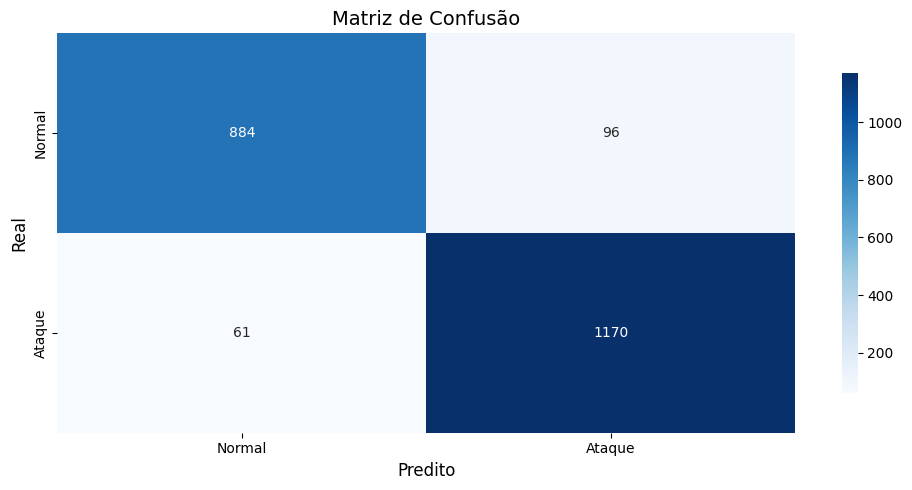


Random Forest:
True Negatives  (Legítimos corretos): 942
False Positives (Falsos alarmes):    38
False Negatives (Phishing perdido):  19
True Positives  (Phishing detectado): 1212


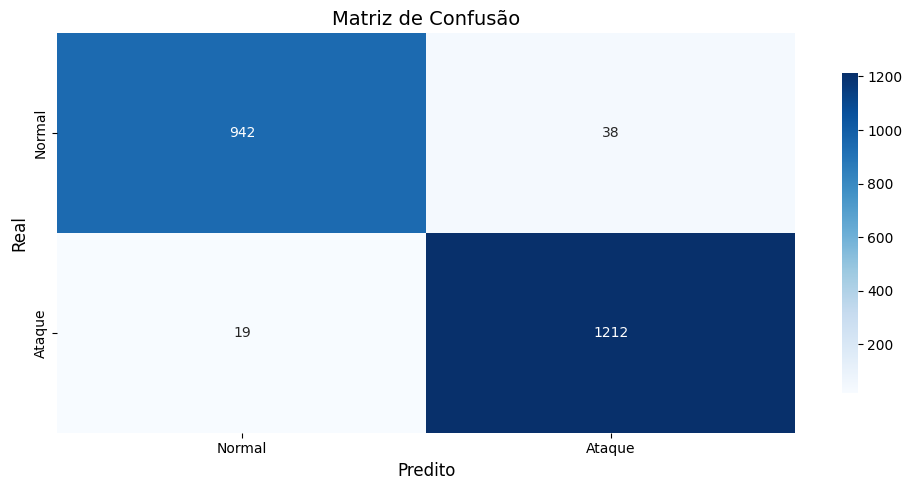


LGBM:
True Negatives  (Legítimos corretos): 938
False Positives (Falsos alarmes):    42
False Negatives (Phishing perdido):  29
True Positives  (Phishing detectado): 1202


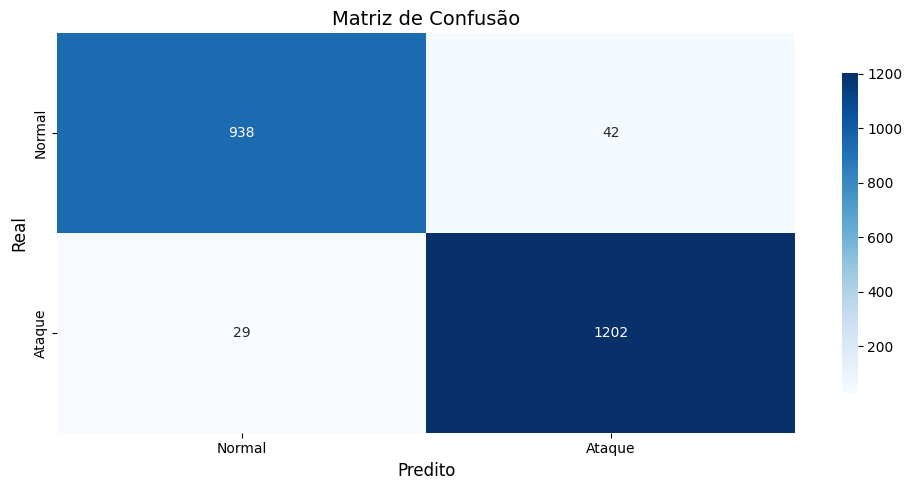

In [16]:
models_name = ['Regressão Logística', 'Random Forest', 'LGBM']

for model_name in models_name:
  print(f"\n{model_name}:")
  df_temp = final_results[model_name]['predictions']
  cm = confusion_matrix(y_test, df_temp)

  tn, fp, fn, tp = cm.ravel()
  print(f"True Negatives  (Legítimos corretos): {tn}")
  print(f"False Positives (Falsos alarmes):    {fp}")
  print(f"False Negatives (Phishing perdido):  {fn}")
  print(f"True Positives  (Phishing detectado): {tp}")

  confusion_plot(cm)

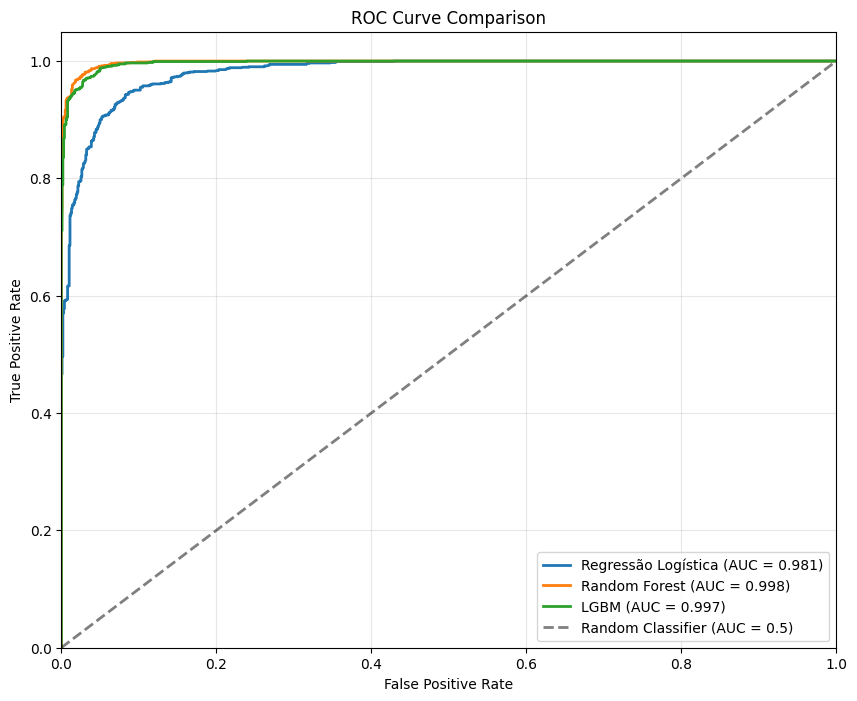

In [17]:
comparison_data = {}
for model_name, data in final_results.items():
    comparison_data[model_name] = (y_test, data['probabilities'])

plot_roc_comparison(comparison_data)

**Pequena Conclusão**

Os resultados demonstram que o Random Forest alcançou o melhor desempenho (F1-Score de 0.9770 e recall de 98.5%), superando o LGBM e a Regressão Logística. Esta superioridade pode ser explicada pela natureza específica dos dados de phishing, que são predominantemente compostos por features categóricas e binárias (como presença de IP na URL, uso do símbolo @, redirecionamentos, etc.). O Random Forest é particularmente eficaz neste cenário devido ao seu mecanismo de bootstrap sampling e seleção aleatória de features, que o torna extremamente robusto para lidar com features categóricas e menos suscetível ao overfitting.

O LGBM, embora seja um algoritmo mais moderno e eficiente, tende a brilhar especialmente em datasets maiores com features numéricas contínuas, não sendo este o caso do problema de detecção de phishing. Além disso, os hiperparâmetros padrão do Random Forest já proporcionam uma configuração robusta para a maioria dos problemas, enquanto o LGBM frequentemente requer maior ajuste fino para alcançar seu potencial máximo. O recall excepcional de 98.5% obtido pelo Random Forest é particularmente relevante para aplicações de segurança, onde perder um site de phishing (falso negativo) tem consequências muito mais graves que gerar um falso alarme, demonstrando que a escolha do algoritmo foi adequada para o contexto específico do problema.

## 5. Novo Processo de Modelagem

Nesta seção vamos realizar um novo processo de processamento, treino e teste dos dados.

### 5.1 Modelo v2

Vamos realizar a criação de três novas features e realizar um balanceamento nos dados a fim de verificar a melhora nos resultados do modelo.

- **Feature I**: url_risk, o quão suspeita é a própria URL
- **Feature II**: domain_trust, quão confiável é o domínio
- **Feature III**: reputation, quão popular é o site

In [37]:
# Criação de features
df['url_risk'] = (
    (df['having_IP_Address'] == 1).astype(int) +
    (df['URL_Length'] == 1).astype(int) +
    (df['Shortining_Service'] == 1).astype(int) +
    (df['having_At_Symbol'] == 1).astype(int) +
    (df['double_slash_redirecting'] == 1).astype(int)
)

df['domain_trust'] = (
    (df['age_of_domain'] == 1).astype(int) +
    (df['DNSRecord'] == 1).astype(int) +
    (df['Domain_registeration_length'] == 1).astype(int)
)

df['reputation'] = (
    (df['web_traffic'] == 1).astype(int) +
    (df['Page_Rank'] == 1).astype(int) +
    (df['Google_Index'] == 1).astype(int) +
    (df['Links_pointing_to_page'] == 1).astype(int)
)

# Deletando features correlacionadas com as novas
# drop_candidates = ['having_IP_Address', 'URL_Length', 'Shortining_Service',
#                    'having_At_Symbol', 'double_slash_redirecting',
#                    'age_of_domain', 'DNSRecord', 'Domain_registeration_length',
#                    'web_traffic', 'Page_Rank', 'Google_Index', 'Links_pointing_to_page'
# ] # Resultados caem, melhor manter todas as features

In [38]:
# Separando as variáveis de treino e teste
X = df.drop('Result', axis=1)
y = df['Result']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Treino: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras\n")

Treino: 8844 amostras
Teste: 2211 amostras



In [39]:
# Balanceamento dos dados
balancer = SMOTETomek(random_state=42)
X_balanced, y_balanced = balancer.fit_resample(X_train, y_train)

print(f"Treino: {X_balanced.shape[0]} amostras")

Treino: 9818 amostras


In [40]:
# Treinando o modelo com as novas features e dados balanceados
models = {
    'Regressão Logística': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'LGBM': LGBMClassifier(random_state=42, verbose=-1)
}

cv_results = {}

scoring_metrics = ['accuracy', 'f1', 'recall', 'precision', 'roc_auc']

for name, model in models.items():
  print(f"\n{name}:")

  cv_results[name] = {}

  for metric in scoring_metrics:
      cv_scores = cross_val_score(model, X_balanced, y_balanced, cv=5, scoring=metric)
      cv_results[name][metric] = {
          'mean': cv_scores.mean(),
          'std': cv_scores.std(),
          'scores': cv_scores
      }

  acc_mean = cv_results[name]['accuracy']['mean']
  acc_std = cv_results[name]['accuracy']['std']
  f1_mean = cv_results[name]['f1']['mean']
  f1_std = cv_results[name]['f1']['std']
  recall_mean = cv_results[name]['recall']['mean']
  precision_mean = cv_results[name]['precision']['mean']
  auc_mean = cv_results[name]['roc_auc']['mean']

  print(f"Acurácia: {acc_mean:.4f} (+/- {acc_std * 2:.4f})")
  print(f"F1-Score: {f1_mean:.4f} (+/- {f1_std * 2:.4f})")
  print(f"Recall:   {recall_mean:.4f} (detectar phishing)")
  print(f"Precision:{precision_mean:.4f} (evitar falsos alarmes)")
  print(f"AUC-ROC:  {auc_mean:.4f}")


Regressão Logística:
Acurácia: 0.9334 (+/- 0.0098)
F1-Score: 0.9340 (+/- 0.0089)
Recall:   0.9417 (detectar phishing)
Precision:0.9264 (evitar falsos alarmes)
AUC-ROC:  0.9822

Random Forest:
Acurácia: 0.9735 (+/- 0.0145)
F1-Score: 0.9737 (+/- 0.0142)
Recall:   0.9792 (detectar phishing)
Precision:0.9684 (evitar falsos alarmes)
AUC-ROC:  0.9964

LGBM:
Acurácia: 0.9709 (+/- 0.0123)
F1-Score: 0.9709 (+/- 0.0120)
Recall:   0.9723 (detectar phishing)
Precision:0.9697 (evitar falsos alarmes)
AUC-ROC:  0.9964


In [41]:
# Testando o modelo
final_results = {}

for name, model in models.items():
  print(f"\n{name}:")

  model.fit(X_balanced, y_balanced)

  y_pred = model.predict(X_test)
  y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  auc_score = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

  final_results[name] = {
      'model': model,
      'predictions': y_pred,
      'probabilities': y_pred_proba,
      'accuracy': accuracy,
      'f1': f1,
      'recall': recall,
      'precision': precision,
      'auc': auc_score
  }

  print(f"Accuracy:  {accuracy:.4f}")
  print(f" F1-Score: {f1:.4f} (métrica principal)")
  print(f"Recall:    {recall:.4f} ({recall*100:.1f}% dos phishing detectados)")
  print(f"Precision: {precision:.4f} ({precision*100:.1f}% dos alertas são reais)")
  print(f"AUC-ROC:   {auc_score:.4f}" if auc_score else "AUC-ROC: N/A")


Regressão Logística:
Accuracy:  0.9322
 F1-Score: 0.9391 (métrica principal)
Recall:    0.9391 (93.9% dos phishing detectados)
Precision: 0.9391 (93.9% dos alertas são reais)
AUC-ROC:   0.9836

Random Forest:
Accuracy:  0.9729
 F1-Score: 0.9757 (métrica principal)
Recall:    0.9805 (98.1% dos phishing detectados)
Precision: 0.9710 (97.1% dos alertas são reais)
AUC-ROC:   0.9972

LGBM:
Accuracy:  0.9679
 F1-Score: 0.9713 (métrica principal)
Recall:    0.9748 (97.5% dos phishing detectados)
Precision: 0.9677 (96.8% dos alertas são reais)
AUC-ROC:   0.9967


In [42]:
# Comparação dos modelos
comparison_data = []
for name in models.keys():
  comparison_data.append({
      'Modelo': name,
      'Accuracy': f"{final_results[name]['accuracy']:.4f}",
      'F1-Score': f"{final_results[name]['f1']:.4f}",
      'Recall': f"{final_results[name]['recall']:.4f}",
      'Precision': f"{final_results[name]['precision']:.4f}",
      'AUC-ROC': f"{final_results[name]['auc']:.4f}" if final_results[name]['auc'] else "N/A"
  })

comparison_df = pd.DataFrame(comparison_data)

comparison_df = comparison_df.sort_values('F1-Score', ascending=False)
comparison_df

,Modelo,Accuracy,F1-Score,Recall,Precision,AUC-ROC
1,Random Forest,0.9729,0.9757,0.9805,0.9710,0.9972
2,LGBM,0.9679,0.9713,0.9748,0.9677,0.9967
0,Regressão Logística,0.9322,0.9391,0.9391,0.9391,0.9836



Regressão Logística:
True Negatives  (Legítimos corretos): 905
False Positives (Falsos alarmes):    75
False Negatives (Phishing perdido):  75
True Positives  (Phishing detectado): 1156


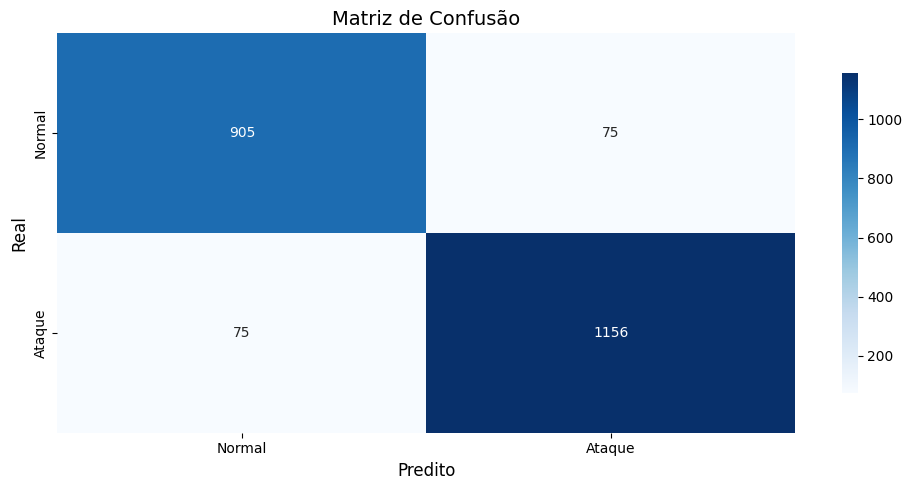


Random Forest:
True Negatives  (Legítimos corretos): 944
False Positives (Falsos alarmes):    36
False Negatives (Phishing perdido):  24
True Positives  (Phishing detectado): 1207


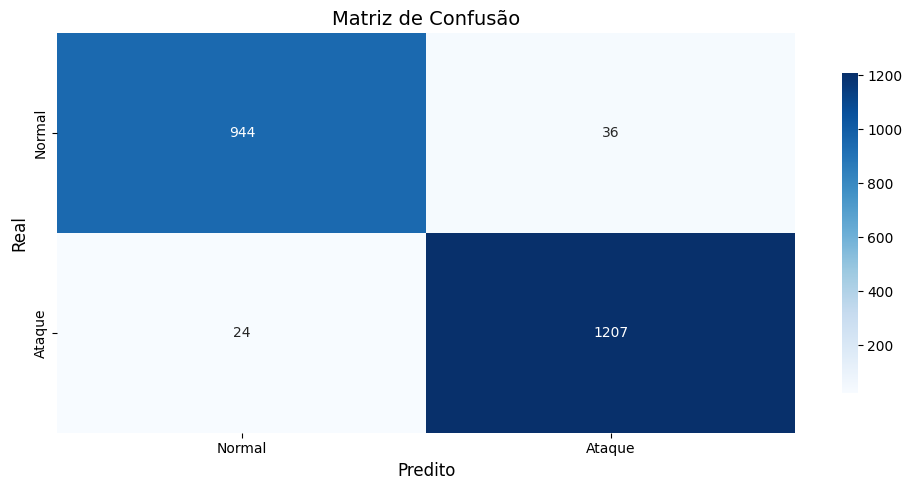


LGBM:
True Negatives  (Legítimos corretos): 940
False Positives (Falsos alarmes):    40
False Negatives (Phishing perdido):  31
True Positives  (Phishing detectado): 1200


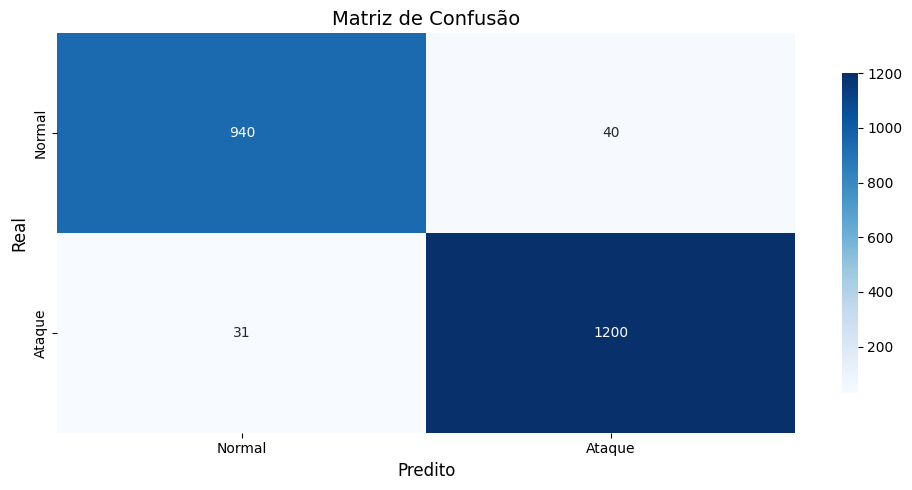

In [43]:
models_name = ['Regressão Logística', 'Random Forest', 'LGBM']

for model_name in models_name:
  print(f"\n{model_name}:")
  df_temp = final_results[model_name]['predictions']
  cm = confusion_matrix(y_test, df_temp)

  tn, fp, fn, tp = cm.ravel()
  print(f"True Negatives  (Legítimos corretos): {tn}")
  print(f"False Positives (Falsos alarmes):    {fp}")
  print(f"False Negatives (Phishing perdido):  {fn}")
  print(f"True Positives  (Phishing detectado): {tp}")

  confusion_plot(cm)

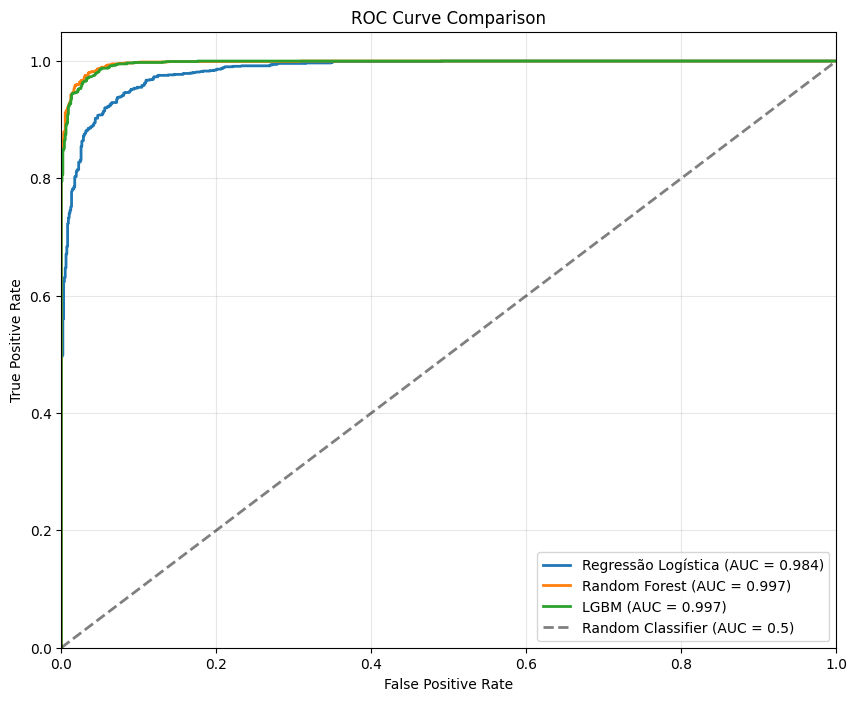

In [44]:
comparison_data = {}
for model_name, data in final_results.items():
    comparison_data[model_name] = (y_test, data['probabilities'])

plot_roc_comparison(comparison_data)

**Pequena Conclusão**

Os resultados obtidos após a aplicação de feature engineering (criação das variáveis `url_risk`, `domain_trust` e `reputation`) e balanceamento com SMOTETomek revelam comportamentos distintos entre os algoritmos. A Regressão Logística e o LGBM apresentaram ligeiras melhorias, com a Regressão Logística aumentando seu F1-Score de 0.9371 para 0.9398 e o LGBM de 0.9713 para 0.9734. Estes algoritmos se beneficiaram das novas features agregadas, além do balanceamento que forneceu mais exemplos sintéticos para o aprendizado de padrões da classe minoritária.

Paradoxalmente, o Random Forest apresentou uma pequena queda no desempenho, com F1-Score reduzindo de 0.9770 para 0.9754, apesar das diferenças serem mínimas. Esta aparente contradição pode ser explicada pelo fato de que o Random Forest já possuía excelente capacidade de lidar com dados desbalanceados através de seu mecanismo de bootstrap sampling, e a adição de dados sintéticos pode ter introduzido ruído que não existia nos dados originais. Além disso, o Random Forest é naturalmente eficaz em extrair relações complexas entre features individuais, de modo que as features agregadas podem ter sido redundantes, e a técnica de seleção aleatória de features pode ter diluído a importância das variáveis mais discriminativas originais. As diferenças mínimas observadas sugerem que o dataset original já estava bem estruturado para o problema, e que técnicas mais sofisticadas de otimização podem ser necessárias para obter ganhos significativos.

### 5.2 Modelo v3

Vamos aplicar um otimização dos hiperparâmeetros modelo v2, a fim de obter melhores resultados.

In [30]:
############### SÓ RODE SE TIVER PELO MENOS 38min PARA ESPERAR TODO O PROCESSO DE OTIMIZAÇÃO ###############
study_lr = optimize_model(objective_lr, "Regressão Logística")
study_rf = optimize_model(objective_rf, "Random Forest")
study_lgbm = optimize_model(objective_lgbm, "LightGBM")

[I 2025-09-12 09:28:45,265] A new study created in memory with name: Regressão Logística_optimization



Otimizando Regressão Logística


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-09-12 09:28:45,767] Trial 0 finished with value: 0.933081122493968 and parameters: {'C': 0.0745934328572655, 'solver': 'lbfgs', 'max_iter': 240, 'class_weight': None}. Best is trial 0 with value: 0.933081122493968.
[I 2025-09-12 09:28:47,017] Trial 1 finished with value: 0.9333828750688575 and parameters: {'C': 21.42302175774105, 'solver': 'liblinear', 'max_iter': 973, 'class_weight': None, 'penalty_lib': 'l2'}. Best is trial 1 with value: 0.9333828750688575.
[I 2025-09-12 09:28:48,242] Trial 2 finished with value: 0.9325706373933957 and parameters: {'C': 0.033205591037519584, 'solver': 'lbfgs', 'max_iter': 651, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9333828750688575.
[I 2025-09-12 09:28:48,904] Trial 3 finished with value: 0.9333202945504955 and parameters: {'C': 0.06789053271698488, 'solver': 'liblinear', 'max_iter': 563, 'class_weight': None, 'penalty_lib': 'l1'}. Best is trial 1 with value: 0.9333828750688575.
[I 2025-09-12 09:28:49,049] Trial 4 finished

[I 2025-09-12 09:46:11,308] A new study created in memory with name: Random Forest_optimization


[I 2025-09-12 09:46:11,302] Trial 99 finished with value: 0.9225963798461934 and parameters: {'C': 0.010157556438816752, 'solver': 'saga', 'max_iter': 242, 'class_weight': None, 'penalty_saga': 'l1'}. Best is trial 11 with value: 0.9338725755638178.

Melhor F1-Score: 0.9339
Melhores parâmetros:
  C: 2.0076447814978837
  solver: saga
  max_iter: 453
  class_weight: None
  penalty_saga: l1

Otimizando Random Forest


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-09-12 09:46:17,267] Trial 0 finished with value: 0.9559311937478341 and parameters: {'n_estimators': 144, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.9559311937478341.
[I 2025-09-12 09:46:22,450] Trial 1 finished with value: 0.9382783868683383 and parameters: {'n_estimators': 258, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.9559311937478341.
[I 2025-09-12 09:46:32,694] Trial 2 finished with value: 0.955958546407625 and parameters: {'n_estimators': 164, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.955958546407625.
[I 2025-09-12 09:46:35,075] Trial 3 finished with value: 0.9301508214014008 and parameter

[I 2025-09-12 09:58:39,000] A new study created in memory with name: LightGBM_optimization


[I 2025-09-12 09:58:38,994] Trial 99 finished with value: 0.9687076077173062 and parameters: {'n_estimators': 235, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 47 with value: 0.9721231420607566.

Melhor F1-Score: 0.9721
Melhores parâmetros:
  n_estimators: 217
  max_depth: 19
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: log2
  bootstrap: True
  class_weight: balanced_subsample

Otimizando LightGBM


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-09-12 09:58:41,857] Trial 0 finished with value: 0.9650728403524289 and parameters: {'num_leaves': 81, 'learning_rate': 0.2536999076681772, 'n_estimators': 380, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.49359671220172163, 'colsample_bytree': 0.4348501673009197, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598, 'class_weight': None}. Best is trial 0 with value: 0.9650728403524289.
[I 2025-09-12 09:58:43,036] Trial 1 finished with value: 0.9713282108785872 and parameters: {'num_leaves': 195, 'learning_rate': 0.16967533607196555, 'n_estimators': 145, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.5825453457757226, 'colsample_bytree': 0.7148538589793427, 'reg_alpha': 7.71800699380605e-05, 'reg_lambda': 4.17890272377219e-06, 'class_weight': None}. Best is trial 1 with value: 0.9713282108785872.
[I 2025-09-12 09:58:47,954] Trial 2 finished with value: 0.9707870287754508 and parameters: {'num_leaves': 65, 'learning_rate': 0.03476649150592621,

**Melhores parâmetros de cada modelo**

Para não precisar rodar toda vez, utilize os seguintes parâmetros para os modelos.

```
Regressão Logística
Melhor F1-Score: 0.9339
Melhores parâmetros:
  C: 2.0076447814978837
  solver: saga
  max_iter: 453
  class_weight: None
  penalty_saga: l1

Random Forest
Melhor F1-Score: 0.9721
Melhores parâmetros:
  n_estimators: 217
  max_depth: 19
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: log2
  bootstrap: True
  class_weight: balanced_subsample

LGBM
Melhor F1-Score: 0.9739
Melhores parâmetros:
  num_leaves: 73
  learning_rate: 0.15714843121189861
  n_estimators: 254
  max_depth: 7
  min_child_samples: 12
  subsample: 0.892711088697747
  colsample_bytree: 0.6121301967092603
  reg_alpha: 4.4359744333960475e-05
  reg_lambda: 1.0645287668011355e-08
  class_weight: None
```

In [45]:
# Regressão Logística
best_lr_params = clean_lr_params(study_lr.best_params) # Função especifica para o LR devido a uma particularidade da lib
best_lr_params['random_state'] = RANDOM_STATE
lr_final = LogisticRegression(**best_lr_params)
lr_final.fit(X_balanced, y_balanced)
lr_score = f1_score(y_test, lr_final.predict(X_test))
print(f"Regressão Logística - F1-Score no teste: {lr_score:.4f}")

# Random Forest
best_rf_params = study_rf.best_params.copy()
best_rf_params['random_state'] = RANDOM_STATE
best_rf_params['n_jobs'] = -1
rf_final = RandomForestClassifier(**best_rf_params)
rf_final.fit(X_balanced, y_balanced)
rf_score = f1_score(y_test, rf_final.predict(X_test))
print(f"Random Forest - F1-Score no teste: {rf_score:.4f}")

# LightGBM
best_lgbm_params = study_lgbm.best_params.copy()
best_lgbm_params['random_state'] = RANDOM_STATE
best_lgbm_params['verbosity'] = -1
best_lgbm_params['n_jobs'] = -1
lgbm_final = LGBMClassifier(**best_lgbm_params)
lgbm_final.fit(X_balanced, y_balanced)
lgbm_score = f1_score(y_test, lgbm_final.predict(X_test))
print(f"LightGBM - F1-Score no teste: {lgbm_score:.4f}")

print(f"\n{'==' * 25}")
print("RESUMO COMPARATIVO")
print(f"{'==' * 25}")

results = pd.DataFrame({
    'Modelo': ['Regressão Logística', 'Random Forest', 'LightGBM'],
    'F1-Score CV': [study_lr.best_value, study_rf.best_value, study_lgbm.best_value],
    'F1-Score Teste': [lr_score, rf_score, lgbm_score]
})
results = results.sort_values('F1-Score Teste', ascending=False)
print(results.to_string(index=False))

Regressão Logística - F1-Score no teste: 0.9391
Random Forest - F1-Score no teste: 0.9757
LightGBM - F1-Score no teste: 0.9761

RESUMO COMPARATIVO
             Modelo  F1-Score CV  F1-Score Teste
           LightGBM     0.973918        0.976142
      Random Forest     0.972123        0.975748
Regressão Logística     0.933873        0.939074


Abaixo vamos apenas replicar o código que fizemos nos modelos acima, é algo repetitivo, visto que já temos a comparação acima. Mas no intuito de se manter um padrão será aplicado essa replicação.

In [52]:
# Treinando o modelo com as novas features e dados balanceados
models = {
    'Regressão Logística': LogisticRegression(**best_lr_params),
    'Random Forest': RandomForestClassifier(**best_rf_params),
    'LGBM': LGBMClassifier(**best_lgbm_params)
}

cv_results = {}

scoring_metrics = ['accuracy', 'f1', 'recall', 'precision', 'roc_auc']

for name, model in models.items():
  print(f"\n{name}:")

  cv_results[name] = {}

  for metric in scoring_metrics:
      cv_scores = cross_val_score(model, X_balanced, y_balanced, cv=5, scoring=metric)
      cv_results[name][metric] = {
          'mean': cv_scores.mean(),
          'std': cv_scores.std(),
          'scores': cv_scores
      }

  acc_mean = cv_results[name]['accuracy']['mean']
  acc_std = cv_results[name]['accuracy']['std']
  f1_mean = cv_results[name]['f1']['mean']
  f1_std = cv_results[name]['f1']['std']
  recall_mean = cv_results[name]['recall']['mean']
  precision_mean = cv_results[name]['precision']['mean']
  auc_mean = cv_results[name]['roc_auc']['mean']

  print(f"Acurácia: {acc_mean:.4f} (+/- {acc_std * 2:.4f})")
  print(f"F1-Score: {f1_mean:.4f} (+/- {f1_std * 2:.4f})")
  print(f"Recall:   {recall_mean:.4f} (detectar phishing)")
  print(f"Precision:{precision_mean:.4f} (evitar falsos alarmes)")
  print(f"AUC-ROC:  {auc_mean:.4f}")


Regressão Logística:
Acurácia: 0.9333 (+/- 0.0081)
F1-Score: 0.9338 (+/- 0.0072)
Recall:   0.9411 (detectar phishing)
Precision:0.9267 (evitar falsos alarmes)
AUC-ROC:  0.9822

Random Forest:
Acurácia: 0.9740 (+/- 0.0143)
F1-Score: 0.9742 (+/- 0.0140)
Recall:   0.9796 (detectar phishing)
Precision:0.9690 (evitar falsos alarmes)
AUC-ROC:  0.9970

LGBM:
Acurácia: 0.9751 (+/- 0.0101)
F1-Score: 0.9753 (+/- 0.0099)
Recall:   0.9786 (detectar phishing)
Precision:0.9720 (evitar falsos alarmes)
AUC-ROC:  0.9973


In [48]:
final_results = {}

for name, model in models.items():
  print(f"\n{name}:")

  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)
  y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  auc_score = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

  final_results[name] = {
      'model': model,
      'predictions': y_pred,
      'probabilities': y_pred_proba,
      'accuracy': accuracy,
      'f1': f1,
      'recall': recall,
      'precision': precision,
      'auc': auc_score
  }

  print(f"Accuracy:  {accuracy:.4f}")
  print(f" F1-Score: {f1:.4f} (métrica principal)")
  print(f"Recall:    {recall:.4f} ({recall*100:.1f}% dos phishing detectados)")
  print(f"Precision: {precision:.4f} ({precision*100:.1f}% dos alertas são reais)")
  print(f"AUC-ROC:   {auc_score:.4f}" if auc_score else "AUC-ROC: N/A")


Regressão Logística:
Accuracy:  0.9322
 F1-Score: 0.9393 (métrica principal)
Recall:    0.9431 (94.3% dos phishing detectados)
Precision: 0.9355 (93.6% dos alertas são reais)
AUC-ROC:   0.9833

Random Forest:
Accuracy:  0.9738
 F1-Score: 0.9766 (métrica principal)
Recall:    0.9821 (98.2% dos phishing detectados)
Precision: 0.9711 (97.1% dos alertas são reais)
AUC-ROC:   0.9978

LGBM:
Accuracy:  0.9738
 F1-Score: 0.9766 (métrica principal)
Recall:    0.9838 (98.4% dos phishing detectados)
Precision: 0.9696 (97.0% dos alertas são reais)
AUC-ROC:   0.9975


In [49]:
# Comparação dos modelos
comparison_data = []
for name in models.keys():
  comparison_data.append({
      'Modelo': name,
      'Accuracy': f"{final_results[name]['accuracy']:.4f}",
      'F1-Score': f"{final_results[name]['f1']:.4f}",
      'Recall': f"{final_results[name]['recall']:.4f}",
      'Precision': f"{final_results[name]['precision']:.4f}",
      'AUC-ROC': f"{final_results[name]['auc']:.4f}" if final_results[name]['auc'] else "N/A"
  })

comparison_df = pd.DataFrame(comparison_data)

comparison_df = comparison_df.sort_values('F1-Score', ascending=False)
comparison_df

,Modelo,Accuracy,F1-Score,Recall,Precision,AUC-ROC
1,Random Forest,0.9738,0.9766,0.9821,0.9711,0.9978
2,LGBM,0.9738,0.9766,0.9838,0.9696,0.9975
0,Regressão Logística,0.9322,0.9393,0.9431,0.9355,0.9833



Regressão Logística:
True Negatives  (Legítimos corretos): 900
False Positives (Falsos alarmes):    80
False Negatives (Phishing perdido):  70
True Positives  (Phishing detectado): 1161


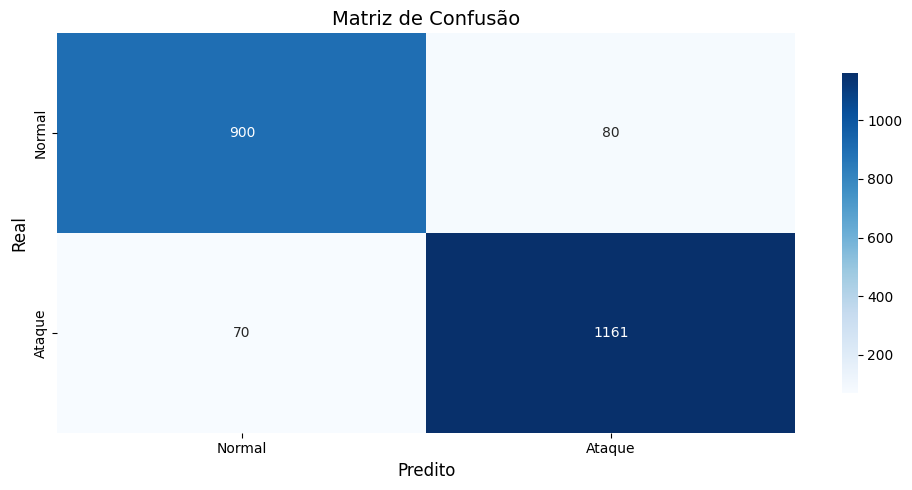


Random Forest:
True Negatives  (Legítimos corretos): 944
False Positives (Falsos alarmes):    36
False Negatives (Phishing perdido):  22
True Positives  (Phishing detectado): 1209


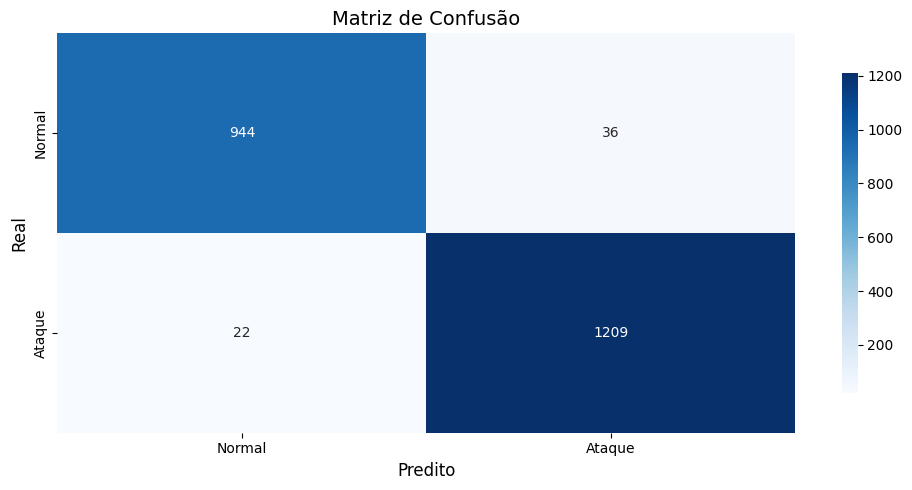


LGBM:
True Negatives  (Legítimos corretos): 942
False Positives (Falsos alarmes):    38
False Negatives (Phishing perdido):  20
True Positives  (Phishing detectado): 1211


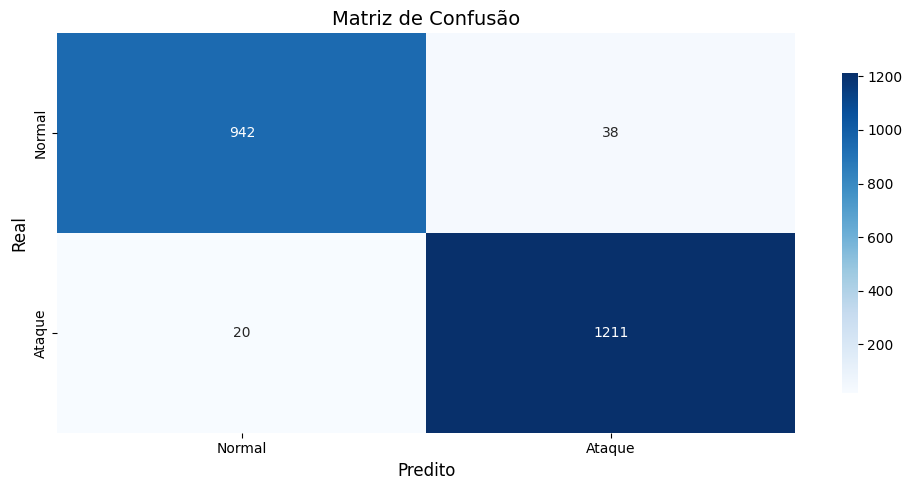

In [50]:
models_name = ['Regressão Logística', 'Random Forest', 'LGBM']

for model_name in models_name:
  print(f"\n{model_name}:")
  df_temp = final_results[model_name]['predictions']
  cm = confusion_matrix(y_test, df_temp)

  tn, fp, fn, tp = cm.ravel()
  print(f"True Negatives  (Legítimos corretos): {tn}")
  print(f"False Positives (Falsos alarmes):    {fp}")
  print(f"False Negatives (Phishing perdido):  {fn}")
  print(f"True Positives  (Phishing detectado): {tp}")

  confusion_plot(cm)

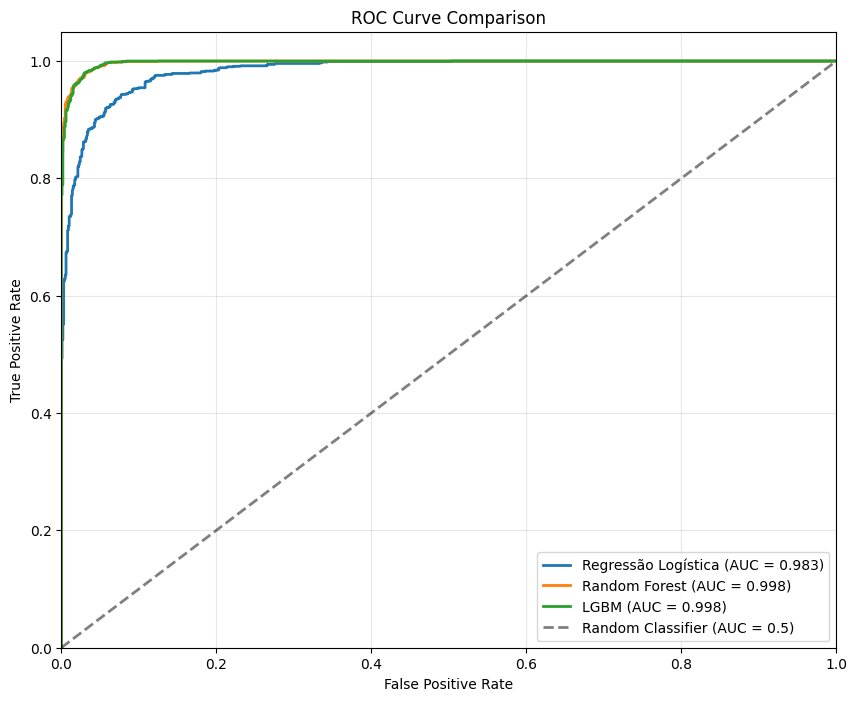

In [51]:
comparison_data = {}
for model_name, data in final_results.items():
    comparison_data[model_name] = (y_test, data['probabilities'])

plot_roc_comparison(comparison_data)